# Module 10: Optimizers

**Beyond Basic Gradient Descent**

---

## Objectives

By the end of this notebook, you will:
- Understand why we need better optimizers than vanilla SGD
- Master SGD with momentum
- Understand AdaGrad, RMSprop, and Adam
- Know how to use learning rate schedulers
- Compare optimizers visually

**Prerequisites:** [Module 08 - Gradient Descent](../08_gradient_descent/08_gradient_descent.ipynb)

---

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
np.random.seed(42)

---

# Part 1: Problems with Vanilla SGD

---

## 1.1 The Ravine Problem

When the loss surface has different curvatures in different directions, SGD oscillates in the steep direction and moves slowly in the flat direction.

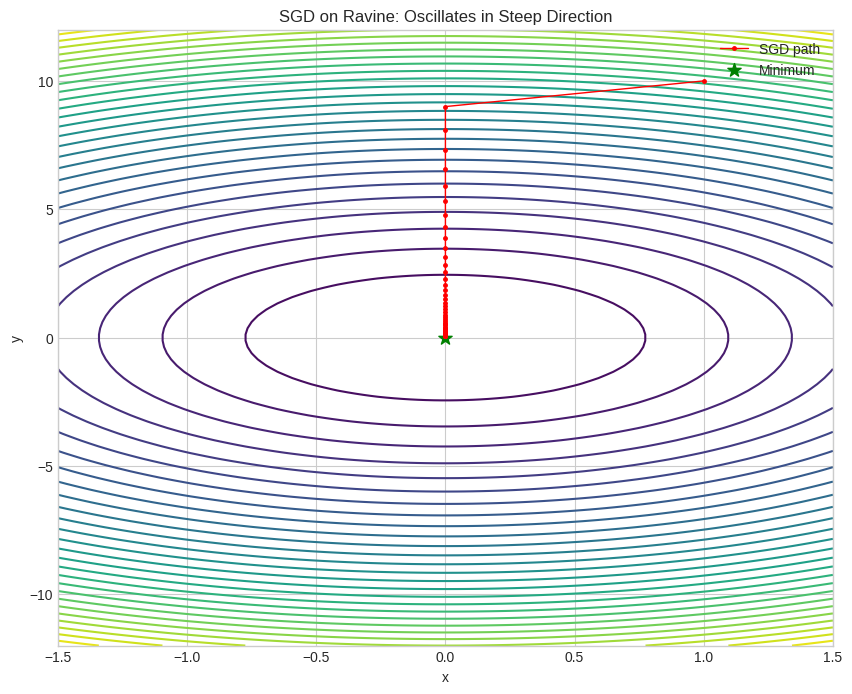

In [2]:
# Visualize the ravine problem
def ravine(x, y):
    """A bowl-shaped function with different curvatures."""
    return 10*x**2 + y**2  # Much steeper in x direction

def ravine_grad(x, y):
    return np.array([20*x, 2*y])

# SGD on ravine
def sgd_optimize(grad_fn, start, lr, n_steps):
    pos = np.array(start, dtype=float)
    history = [pos.copy()]
    for _ in range(n_steps):
        grad = grad_fn(*pos)
        pos = pos - lr * grad
        history.append(pos.copy())
    return np.array(history)

# Run SGD
history_sgd = sgd_optimize(ravine_grad, [1.0, 10.0], lr=0.05, n_steps=50)

# Plot
fig, ax = plt.subplots(figsize=(10, 8))

x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-12, 12, 100)
X, Y = np.meshgrid(x, y)
Z = ravine(X, Y)

ax.contour(X, Y, Z, levels=30, cmap='viridis')
ax.plot(history_sgd[:, 0], history_sgd[:, 1], 'r.-', linewidth=1, markersize=5, label='SGD path')
ax.scatter([0], [0], c='green', s=100, marker='*', label='Minimum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('SGD on Ravine: Oscillates in Steep Direction')
ax.legend()
plt.show()

---

# Part 2: SGD with Momentum

---

## 2.1 The Idea

Accumulate velocity in directions with consistent gradients:

$$v_t = \beta v_{t-1} + \nabla L(\theta_t)$$
$$\theta_{t+1} = \theta_t - \alpha v_t$$

Where $\beta$ is the momentum coefficient (typically 0.9).

**Intuition:** Like a ball rolling downhill - it builds up speed in consistent directions and dampens oscillations.

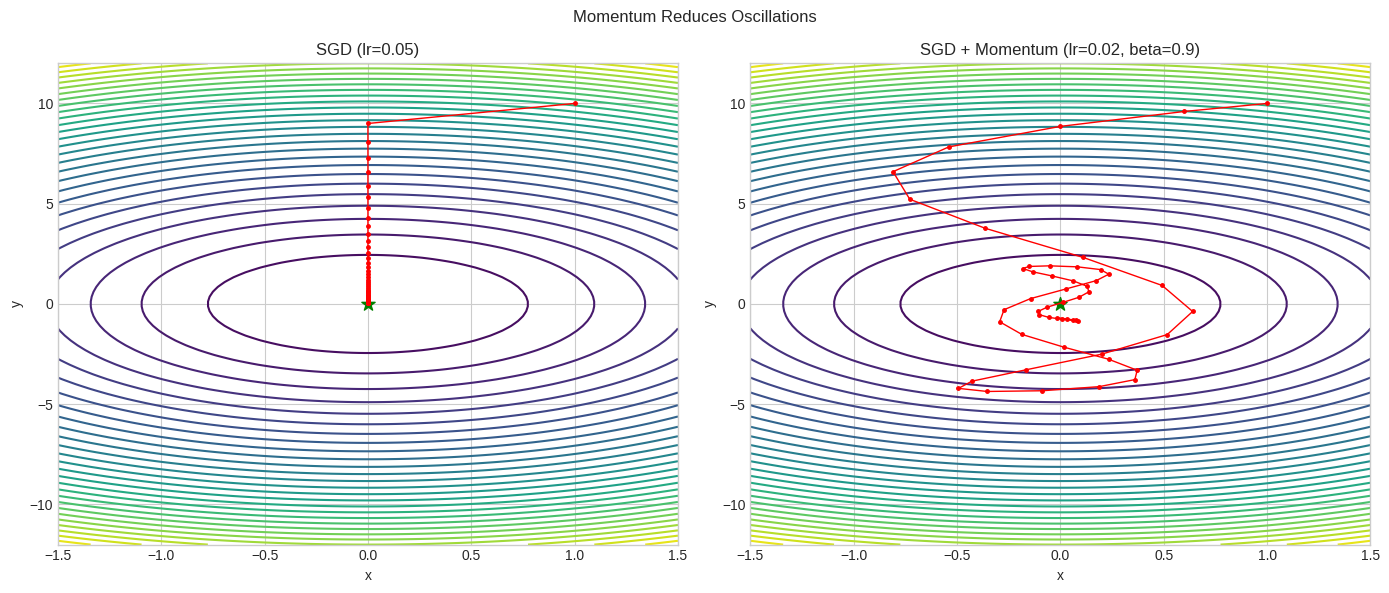

In [3]:
def sgd_momentum_optimize(grad_fn, start, lr, momentum, n_steps):
    pos = np.array(start, dtype=float)
    velocity = np.zeros_like(pos)
    history = [pos.copy()]

    for _ in range(n_steps):
        grad = grad_fn(*pos)
        velocity = momentum * velocity + grad
        pos = pos - lr * velocity
        history.append(pos.copy())

    return np.array(history)

# Compare SGD vs Momentum
history_sgd = sgd_optimize(ravine_grad, [1.0, 10.0], lr=0.05, n_steps=50)
history_mom = sgd_momentum_optimize(ravine_grad, [1.0, 10.0], lr=0.02, momentum=0.9, n_steps=50)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, history, title in zip(axes, [history_sgd, history_mom], ['SGD (lr=0.05)', 'SGD + Momentum (lr=0.02, beta=0.9)']):
    ax.contour(X, Y, Z, levels=30, cmap='viridis')
    ax.plot(history[:, 0], history[:, 1], 'r.-', linewidth=1, markersize=5)
    ax.scatter([0], [0], c='green', s=100, marker='*')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(title)

plt.suptitle('Momentum Reduces Oscillations', fontsize=12)
plt.tight_layout()
plt.show()

---

# Part 3: Adaptive Learning Rate Methods

---

## 3.1 AdaGrad

Adapts learning rate per parameter based on historical gradients:

$$G_t = G_{t-1} + g_t^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{G_t + \epsilon}} g_t$$

**Effect:** Parameters with large gradients get smaller learning rates.

In [4]:
def adagrad_optimize(grad_fn, start, lr, n_steps, epsilon=1e-8):
    pos = np.array(start, dtype=float)
    G = np.zeros_like(pos)
    history = [pos.copy()]

    for _ in range(n_steps):
        grad = grad_fn(*pos)
        G = G + grad ** 2
        pos = pos - lr * grad / (np.sqrt(G) + epsilon)
        history.append(pos.copy())

    return np.array(history)

history_adagrad = adagrad_optimize(ravine_grad, [1.0, 10.0], lr=5.0, n_steps=50)

## 3.2 RMSprop

Like AdaGrad but uses exponentially decaying average:

$$E[g^2]_t = \beta E[g^2]_{t-1} + (1-\beta) g_t^2$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{E[g^2]_t + \epsilon}} g_t$$

**Advantage:** Doesn't accumulate forever like AdaGrad.

In [5]:
def rmsprop_optimize(grad_fn, start, lr, beta=0.9, n_steps=50, epsilon=1e-8):
    pos = np.array(start, dtype=float)
    Eg2 = np.zeros_like(pos)
    history = [pos.copy()]

    for _ in range(n_steps):
        grad = grad_fn(*pos)
        Eg2 = beta * Eg2 + (1 - beta) * grad ** 2
        pos = pos - lr * grad / (np.sqrt(Eg2) + epsilon)
        history.append(pos.copy())

    return np.array(history)

history_rmsprop = rmsprop_optimize(ravine_grad, [1.0, 10.0], lr=0.5, beta=0.9, n_steps=50)

## 3.3 Adam

Combines momentum and adaptive learning rate:

$$m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t$$
$$v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2$$
$$\hat{m}_t = \frac{m_t}{1 - \beta_1^t}$$
$$\hat{v}_t = \frac{v_t}{1 - \beta_2^t}$$
$$\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t$$

Default: $\beta_1=0.9$, $\beta_2=0.999$

In [6]:
def adam_optimize(grad_fn, start, lr, beta1=0.9, beta2=0.999, n_steps=50, epsilon=1e-8):
    pos = np.array(start, dtype=float)
    m = np.zeros_like(pos)
    v = np.zeros_like(pos)
    history = [pos.copy()]

    for t in range(1, n_steps + 1):
        grad = grad_fn(*pos)

        # Update biased first moment estimate
        m = beta1 * m + (1 - beta1) * grad
        # Update biased second moment estimate
        v = beta2 * v + (1 - beta2) * grad ** 2

        # Bias correction
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)

        # Update parameters
        pos = pos - lr * m_hat / (np.sqrt(v_hat) + epsilon)
        history.append(pos.copy())

    return np.array(history)

history_adam = adam_optimize(ravine_grad, [1.0, 10.0], lr=0.5, n_steps=50)

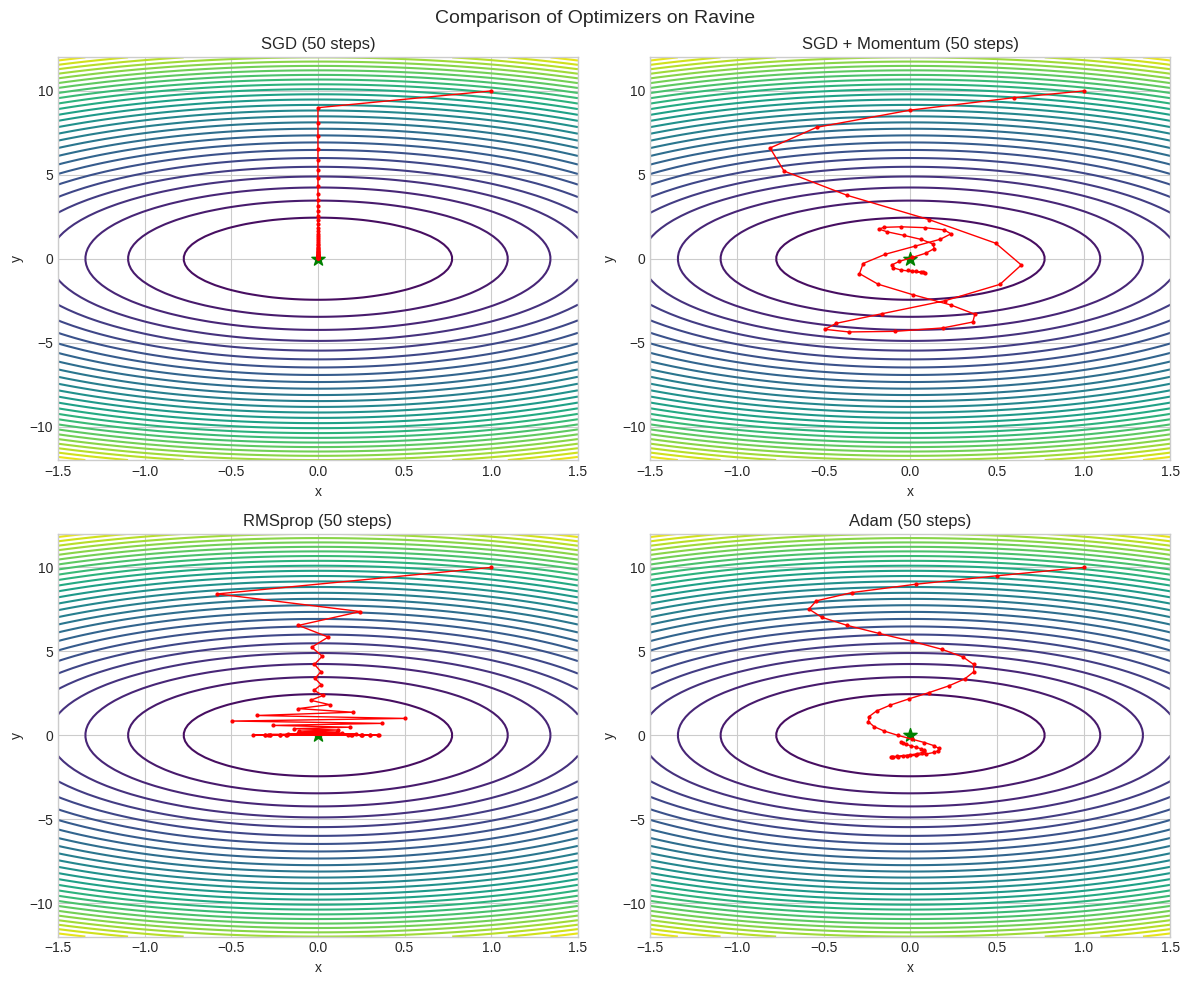

In [7]:
# Compare all optimizers
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

optimizers = [
    (history_sgd, 'SGD'),
    (history_mom, 'SGD + Momentum'),
    (history_rmsprop, 'RMSprop'),
    (history_adam, 'Adam')
]

for ax, (history, name) in zip(axes.flatten(), optimizers):
    ax.contour(X, Y, Z, levels=30, cmap='viridis')
    ax.plot(history[:, 0], history[:, 1], 'r.-', linewidth=1, markersize=4)
    ax.scatter([0], [0], c='green', s=100, marker='*')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_title(f'{name} ({len(history)-1} steps)')

plt.suptitle('Comparison of Optimizers on Ravine', fontsize=14)
plt.tight_layout()
plt.show()

---

# Part 4: PyTorch Optimizers

---

In [8]:
# PyTorch optimizer usage
model = nn.Linear(10, 1)

# Different optimizers
sgd = optim.SGD(model.parameters(), lr=0.01)
sgd_momentum = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
adagrad = optim.Adagrad(model.parameters(), lr=0.01)
rmsprop = optim.RMSprop(model.parameters(), lr=0.01)
adam = optim.Adam(model.parameters(), lr=0.001)  # Note: Adam typically uses smaller lr

print("Available optimizers in PyTorch:")
print("  optim.SGD(params, lr, momentum=0, weight_decay=0)")
print("  optim.Adam(params, lr=0.001, betas=(0.9, 0.999))")
print("  optim.RMSprop(params, lr=0.01, alpha=0.99)")
print("  optim.AdamW(params, lr=0.001)  # Adam with proper weight decay")

Available optimizers in PyTorch:
  optim.SGD(params, lr, momentum=0, weight_decay=0)
  optim.Adam(params, lr=0.001, betas=(0.9, 0.999))
  optim.RMSprop(params, lr=0.01, alpha=0.99)
  optim.AdamW(params, lr=0.001)  # Adam with proper weight decay


In [9]:
# Training loop pattern
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Dummy data
X = torch.randn(100, 10)
y = torch.randn(100, 1)

# Training step
for epoch in range(5):
    # Forward pass
    pred = model(X)
    loss = criterion(pred, y)

    # Backward pass
    optimizer.zero_grad()  # Clear old gradients
    loss.backward()        # Compute gradients
    optimizer.step()       # Update parameters

    print(f"Epoch {epoch+1}: Loss = {loss.item():.4f}")

Epoch 1: Loss = 1.4413
Epoch 2: Loss = 1.3934
Epoch 3: Loss = 1.3484
Epoch 4: Loss = 1.3064
Epoch 5: Loss = 1.2675


---

# Part 5: Learning Rate Scheduling

---

## 5.1 Why Schedule?

- Start with large LR for fast progress
- Reduce LR for fine-tuning near minimum
- Can escape local minima early, converge precisely later

In [10]:
# Common schedulers
model = nn.Linear(10, 1)
optimizer = optim.SGD(model.parameters(), lr=0.1)

# StepLR: reduce by factor every N epochs
step_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)

# ExponentialLR: reduce by factor every epoch
exp_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

# CosineAnnealingLR: follows cosine curve
cos_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# ReduceLROnPlateau: reduce when metric plateaus
plateau_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10)

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


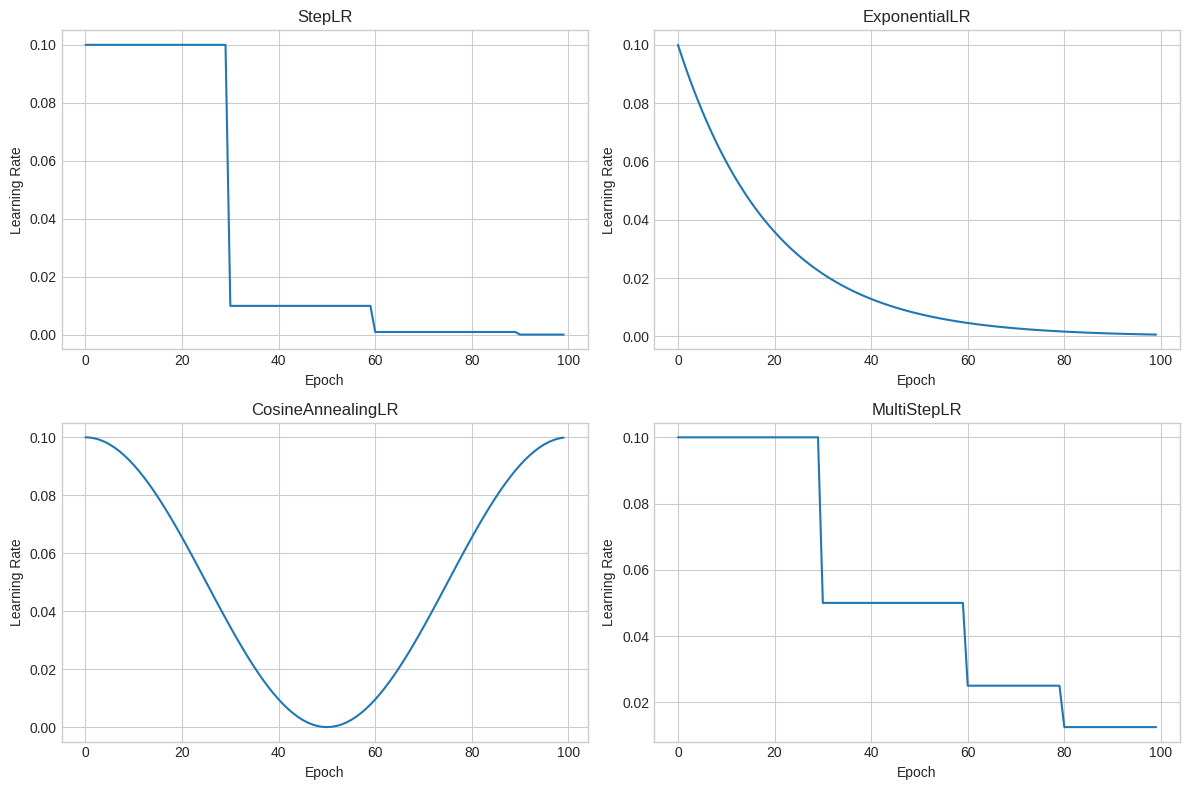

In [11]:
# Visualize different schedulers
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

schedulers = [
    (optim.lr_scheduler.StepLR, {'step_size': 30, 'gamma': 0.1}, 'StepLR'),
    (optim.lr_scheduler.ExponentialLR, {'gamma': 0.95}, 'ExponentialLR'),
    (optim.lr_scheduler.CosineAnnealingLR, {'T_max': 50}, 'CosineAnnealingLR'),
    (optim.lr_scheduler.MultiStepLR, {'milestones': [30, 60, 80], 'gamma': 0.5}, 'MultiStepLR')
]

for ax, (scheduler_cls, kwargs, name) in zip(axes.flatten(), schedulers):
    model = nn.Linear(10, 1)
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    scheduler = scheduler_cls(optimizer, **kwargs)

    lrs = []
    for epoch in range(100):
        lrs.append(optimizer.param_groups[0]['lr'])
        scheduler.step()

    ax.plot(lrs)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Learning Rate')
    ax.set_title(name)

plt.tight_layout()
plt.show()

In [12]:
# Using scheduler in training loop
model = nn.Linear(10, 1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

X = torch.randn(100, 10)
y = torch.randn(100, 1)

for epoch in range(15):
    pred = model(X)
    loss = nn.MSELoss()(pred, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Step scheduler after optimizer.step()
    scheduler.step()

    lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1:2d}: LR = {lr:.6f}, Loss = {loss.item():.4f}")

Epoch  1: LR = 0.010000, Loss = 1.1424
Epoch  2: LR = 0.010000, Loss = 1.1110
Epoch  3: LR = 0.010000, Loss = 1.0821
Epoch  4: LR = 0.010000, Loss = 1.0556
Epoch  5: LR = 0.005000, Loss = 1.0313
Epoch  6: LR = 0.005000, Loss = 1.0088
Epoch  7: LR = 0.005000, Loss = 0.9982
Epoch  8: LR = 0.005000, Loss = 0.9879
Epoch  9: LR = 0.005000, Loss = 0.9779
Epoch 10: LR = 0.002500, Loss = 0.9683
Epoch 11: LR = 0.002500, Loss = 0.9590
Epoch 12: LR = 0.002500, Loss = 0.9545
Epoch 13: LR = 0.002500, Loss = 0.9501
Epoch 14: LR = 0.002500, Loss = 0.9457
Epoch 15: LR = 0.001250, Loss = 0.9415


---

# Part 6: Choosing an Optimizer

---

## Quick Guide

| Optimizer | When to Use |
|-----------|-------------|
| SGD | Understanding/debugging, convex problems |
| SGD + Momentum | Good baseline, often with LR scheduling |
| Adam | Default choice, works well out of the box |
| AdamW | When using weight decay |
| RMSprop | RNNs, but Adam usually better |

**Rule of thumb:** Start with Adam (lr=0.001), then try SGD + Momentum if needed.

---

# Key Points Summary

---

## Momentum
- Accumulates velocity in consistent directions
- Reduces oscillations, speeds up convergence
- Typical: beta = 0.9

## Adaptive Methods
- **AdaGrad**: Per-parameter LR based on accumulated gradients
- **RMSprop**: Decaying average instead of sum
- **Adam**: Momentum + adaptive LR (most popular)

## Learning Rate Scheduling
- Start high, reduce over time
- StepLR, CosineAnnealing, ReduceLROnPlateau

## PyTorch Pattern
```python
optimizer.zero_grad()
loss.backward()
optimizer.step()
scheduler.step()  # After optimizer.step()
```

---

# Interview Tips

---

## Common Questions

**Q: Why use Adam over SGD?**
A: Adam combines momentum (smooths updates) with adaptive learning rates (different LR per parameter). It works well with default settings and requires less tuning. SGD + momentum can match or beat Adam but needs careful LR tuning.

**Q: What does momentum do?**
A: Momentum accumulates a moving average of past gradients. This helps the optimizer build velocity in consistent directions, reducing oscillations and speeding through flat regions.

**Q: What is the bias correction in Adam?**
A: The running averages m and v start at zero, so early estimates are biased toward zero. Bias correction divides by (1 - beta^t) to compensate, especially important in early iterations.

---

# Practice Exercises

---

## Exercise 1: Compare Optimizers on MNIST

Train a simple network on MNIST with different optimizers and compare convergence.

In [13]:
# Your code here
# Hint: Use torchvision.datasets.MNIST

## Exercise 2: Implement Nesterov Momentum

Nesterov momentum: look ahead before computing gradient.
$$v_t = \beta v_{t-1} + \nabla L(\theta_t - \beta v_{t-1})$$

In [14]:
# Your code here

---

## Next Module: [11 - Building Neural Networks in PyTorch](../11_building_nn/11_building_nn.ipynb)

Now that we understand optimizers, let's learn how to build neural networks using PyTorch's nn module.